<center>
<img src="../../img/ods_stickers.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Authors: [Olga Daykhovskaya](https://www.linkedin.com/in/odaykhovskaya/), [Yury Kashnitskiy](https://yorko.github.io). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #7 (demo)
## <center> Unupervised learning

**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a7-demo-unsupervised-learning) + [solution](https://www.kaggle.com/kashnitsky/a7-demo-unsupervised-learning-solution).**

In this task, we will look at how data dimensionality reduction and clustering methods work. At the same time, we'll practice solving classification task again.

We will work with the [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. Download the data [here](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). The data comes from accelerometers and gyros of Samsung Galaxy S3 mobile phones ( you can find more info about the features using the link above), the type of activity of a person with a phone in his/her pocket is also known – whether he/she walked, stood, lay, sat or walked up or down the stairs.

First, we pretend that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then we solve the problem of determining the type of physical activity as a classification problem.

Fill the code where needed ("Your code is here") and answer the questions in the [web form](https://docs.google.com/forms/d/1wBf5UoRndv6PpzIwYnM9f0ysoGa4Yqcqle-HBlBP5QQ/edit).

In [90]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
# from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
PATH_TO_SAMSUNG_DATA = "../../data/samsung_HAR"

In [3]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "samsung_train_labels.txt")).astype(int)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "samsung_test_labels.txt")).astype(int)

In [4]:
# Checking dimensions
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

For clustering, we do not need a target vector, so we'll work with the combination of training and test samples. Merge `X_train` with `X_test`, and `y_train` with `y_test`.

In [10]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [17]:
pd.DataFrame(y_train)

,0
0,5
1,5
2,5
3,5
4,5
...,...
7347,2
7348,2
7349,2
7350,2


In [59]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

Define the number of unique values of the labels of the target class.

In [19]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [20]:
n_classes = np.unique(y).size

[These labels correspond to:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 – walking
- 2 – walking upstairs
- 3 – walking downstairs
- 4 – sitting
- 5 – standing
- 6 – laying down

Scale the sample using `StandardScaler` with default parameters.

*Notes: Features are normalized and bounded within [-1,1].*

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
pd.DataFrame(X_scaled)

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.210534,-0.068703,-0.452195,-0.883335,-0.945431,-0.744387,-0.874687,-0.944877,-0.773250,-0.868773,...,-0.819093,-0.000264,-0.299902,-0.357898,0.062039,-0.782988,-0.019034,-0.674432,0.382008,-0.016151
1,0.060208,0.035902,-0.275222,-0.890098,-0.929817,-0.860322,-0.883627,-0.927796,-0.858859,-0.884263,...,0.127803,-0.925905,-0.789555,0.135993,-0.022538,-1.217721,1.470315,-0.681360,0.383148,-0.000121
2,0.078460,-0.046427,-0.085548,-0.883565,-0.913598,-0.906457,-0.878093,-0.904569,-0.908437,-0.876139,...,1.172610,-0.287824,-0.461181,-0.375145,0.391762,0.134732,1.686961,-0.689471,0.384289,0.019214
3,0.071375,-0.227794,-0.270741,-0.885188,-0.946015,-0.935521,-0.879495,-0.943980,-0.938095,-0.876139,...,1.132149,0.566244,0.436736,-0.132194,-0.034739,1.010013,-0.982261,-0.688915,0.388536,0.024624
4,0.033738,0.031617,-0.121380,-0.889855,-0.940846,-0.935041,-0.882451,-0.937622,-0.940948,-0.883152,...,-0.158720,-0.165153,-0.263958,0.343504,0.268015,1.096950,-1.251689,-0.687381,0.399066,0.038649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.529503,-0.960174,0.185107,0.729285,0.738886,0.985976,0.671427,0.778479,0.959693,1.210539,...,-0.212834,-0.242630,-0.431080,-1.025409,0.768198,1.407463,-1.422736,-0.303659,0.691994,0.889111
10295,1.316644,-0.578309,0.056759,0.689343,1.076214,1.032342,0.629191,1.023717,0.864009,1.210539,...,-0.101244,-0.068167,-0.267420,-2.211711,-0.839484,-1.095665,0.684415,-0.310406,0.688561,0.880288
10296,1.118216,1.288059,-0.129415,0.634062,0.935694,0.899035,0.594164,0.810529,0.671554,0.880306,...,-0.786194,0.561361,0.487469,-0.562328,0.192082,1.101957,0.768150,-0.310750,0.691509,0.875719
10297,-0.543493,0.975327,0.234320,0.648934,0.560590,1.004592,0.583607,0.508257,0.815788,0.880306,...,-0.705592,0.290917,-0.000118,1.297936,-1.837152,1.479507,0.001693,-0.319284,0.659762,0.899444


Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled dataset and fix `random_state` (RANDOM_STATE constant).

In [39]:
pca = PCA(0.9, random_state=RANDOM_STATE, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

In [41]:
pd.DataFrame(X_pca)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-16.380980,1.995083,3.415690,-0.649858,7.825062,-2.771964,2.298285,5.227723,-1.335530,-3.760130,...,-1.506035,-0.781218,2.298251,0.762634,-0.793773,-0.966931,-0.538175,0.342570,-0.243974,-1.946787
1,-15.582173,1.182594,-0.321207,2.748083,4.729536,-1.588823,-0.334051,1.621178,-0.006349,0.072030,...,0.825520,-1.238370,0.574630,0.279049,0.455333,-0.326308,-0.308416,0.137421,-0.160813,-0.614320
2,-15.423989,2.243166,-1.237784,4.002881,4.402735,-1.035089,-0.129769,1.279185,0.190748,-0.780891,...,-0.049957,-0.094588,0.482925,0.982975,-0.048405,0.040423,0.061110,-1.470980,-1.243111,0.246722
3,-15.647807,3.762882,-1.275283,2.806663,3.239111,-0.743524,0.326070,1.742983,0.912218,-1.594744,...,0.308788,1.567928,0.372501,0.706237,1.081383,-0.595845,0.647765,-2.245285,1.007824,4.239617
4,-15.842320,4.438897,-1.808232,3.160507,3.331172,-0.911551,-0.861931,0.090126,0.521629,1.015852,...,-0.006348,-0.073779,-0.743167,0.648799,0.406167,0.199058,0.392289,-0.494461,-0.798755,-0.165762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,10.166057,-6.504223,-1.055480,3.284351,-3.092322,1.826406,1.115329,-3.700841,-0.458237,0.227647,...,0.523421,-0.789725,1.049283,0.176700,0.080074,1.346695,-0.358640,-0.128719,-0.479910,-0.985991
10295,12.131154,-4.882447,-0.652943,2.843124,-1.855674,-0.237809,0.942492,-1.649241,-1.255467,1.501563,...,0.724734,-1.360103,0.368710,0.329186,0.082377,1.727428,-0.847686,0.183105,0.625335,-1.039937
10296,11.846853,-3.433565,2.188019,2.376461,-0.097417,0.339711,1.477391,-0.108231,-1.133958,-0.485808,...,0.596142,-1.375539,-0.032523,-1.950166,-2.138688,-1.900237,-3.680339,-0.944670,-0.344980,-2.094656
10297,8.206686,-4.386489,1.318720,3.571492,-0.861809,0.819570,2.610082,-1.137181,-1.477443,-0.533054,...,0.262820,1.168796,-1.263935,-1.412382,0.188709,1.092362,-0.877534,0.117234,-1.327861,0.087424


**Question 1:** <br>
What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data?

In [31]:
pca.n_components_

65

**Answer options:**
- 56 
- **65**
- 66
- 193

**Question 2:**<br>
What percentage of the variance is covered by the first principal component? Round to the nearest percent.

**Answer options:**
- 45
- **51**
- 56
- 61

In [35]:
pca.explained_variance_ratio_

array([0.50738221, 0.06239186, 0.02692564, 0.02452871, 0.01888936,
       0.01631395, 0.01414533, 0.01216211, 0.00985248, 0.00949228,
       0.00858304, 0.0080998 , 0.00765863, 0.00676668, 0.00630242,
       0.00615718, 0.00595335, 0.00577195, 0.00563431, 0.0054083 ,
       0.00518828, 0.00502742, 0.00473229, 0.00463818, 0.00446848,
       0.00439868, 0.00416863, 0.00400809, 0.00389072, 0.00381339,
       0.0036687 , 0.00364357, 0.00349225, 0.00346736, 0.00335539,
       0.00329411, 0.00323824, 0.00300508, 0.00294254, 0.00290452,
       0.00275765, 0.00269864, 0.00264196, 0.0025803 , 0.00255031,
       0.00247776, 0.00245537, 0.0023829 , 0.00235902, 0.00232044,
       0.0022836 , 0.00219182, 0.00212631, 0.00209145, 0.0020348 ,
       0.00201167, 0.00198111, 0.00194391, 0.00192509, 0.00189539,
       0.00186403, 0.00182923, 0.00180956, 0.00176364, 0.00174188])

Visualize data in projection on the first two principal components.

[These labels correspond to:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 – walking
- 2 – walking upstairs
- 3 – walking downstairs
- 4 – sitting
- 5 – standing
- 6 – laying down

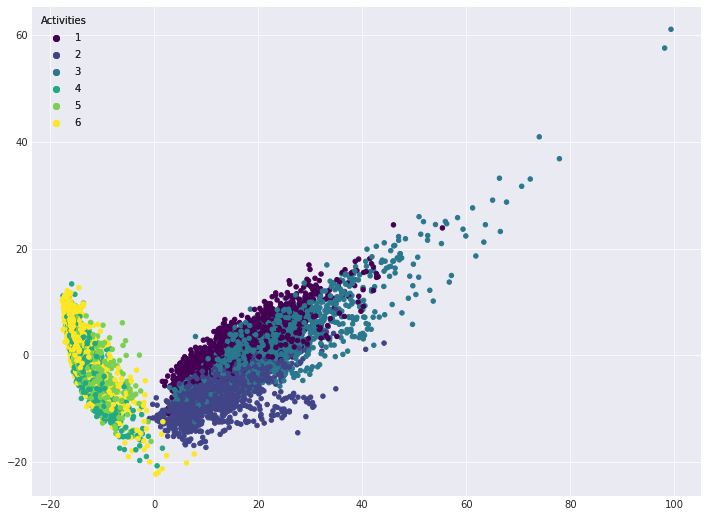

In [66]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1] , c=y, s=20, cmap='viridis')

# produce a legend with the unique colors from the scatter
kw = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying down'
}
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Activities")
ax.add_artist(legend1);

**Question 3:**<br>
If everything worked out correctly, you will see a number of clusters, almost perfectly separated from each other. What types of activity are included in these clusters? <br>

**Answer options:**
- 1 cluster: all 6 activities
- **2 clusters: (walking, walking upstairs, walking downstairs ) and (sitting, standing, laying)**
- 3 clusters: (walking), (walking upstairs, walking downstairs) and (sitting, standing, laying)
- 6 clusters

------------------------------

Perform clustering with the `KMeans` method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.

Options:

- **n_clusters** = n_classes (number of unique labels of the target class)
- **n_init** = 100
- **random_state** = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

In [67]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)

KMeans(n_clusters=6, n_init=100, random_state=17)

Visualize data in projection on the first two principal components. Color the dots according to the clusters obtained.

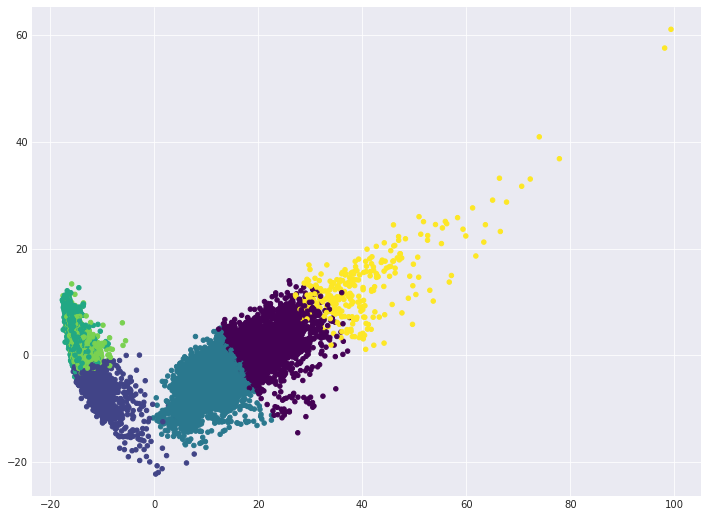

In [68]:
cluster_labels = kmeans.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1] , c=cluster_labels, s=20, cmap='viridis');

Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the `KMeans` algorithm is confused at.

In [71]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,741,0,903,0,0,78,1722
going up the stairs,296,2,1241,0,0,5,1544
going down the stairs,890,0,320,0,0,196,1406
sitting,0,450,1,91,1235,0,1777
standing,0,562,0,0,1344,0,1906
laying,0,329,5,1558,52,0,1944
all,1927,1343,2470,1649,2631,279,10299


We see that for each class (i.e., each activity) there are several clusters. Let's look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class is separated from others when clustering.

Example: if for class "walking downstairs" (with 1406 instances belonging to it), the distribution of clusters is:
 - cluster 1 - 900
 - cluster 3 - 500
 - cluster 6 - 6,
 
then such a share will be 900/1406 $ \approx $ 0.64.
 

**Question 4:** <br>
Which activity is separated from the rest better than others based on the simple metric described above? <br>

**Answer:**
- walking
- standing
- walking downstairs
- **all three options are incorrect**

In [85]:
tab.div(tab['all'], axis=0)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0.430314,0.000000,0.524390,0.000000,0.000000,0.045296,1.0
going up the stairs,0.191710,0.001295,0.803756,0.000000,0.000000,0.003238,1.0
going down the stairs,0.633001,0.000000,0.227596,0.000000,0.000000,0.139403,1.0
sitting,0.000000,0.253236,0.000563,0.051210,0.694992,0.000000,1.0
standing,0.000000,0.294858,0.000000,0.000000,0.705142,0.000000,1.0
laying,0.000000,0.169239,0.002572,0.801440,0.026749,0.000000,1.0
all,0.187106,0.130401,0.239829,0.160113,0.255462,0.027090,1.0


It can be seen that kMeans does not distinguish activities very well. Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only `n_clusters`.

In [91]:
inertia = []
for k in tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

  0%|          | 0/6 [00:00<?, ?it/s]

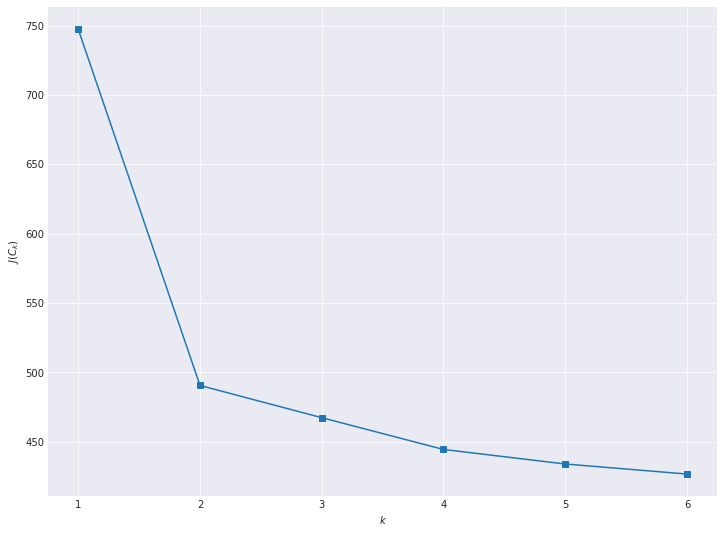

In [92]:
plt.plot(range(1, 7), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**Question 5:** <br>
How many clusters can we choose according to the elbow method? <br>

**Answer options:**
- 1
- **2**
- 3
- 4

------------------------

Let's try another clustering algorithm, described in the article – agglomerative clustering.

In [93]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)

Calculate the Adjusted Rand Index (`sklearn.metrics`) for the resulting clustering and for ` KMeans` with the parameters from the 4th question.

In [95]:
metrics.adjusted_rand_score(y, kmeans.labels_), metrics.adjusted_rand_score(y, ag.labels_)

(0.4610348741359017, 0.49362763373004886)

**Question 6:** <br>
Select all the correct statements. <br>

**Answer options:**
- **According to ARI, KMeans handled clustering worse than Agglomerative Clustering**
- **For ARI, it does not matter which tags are assigned to the cluster, only the partitioning of instances into clusters matters**
- **In case of random partitioning into clusters, ARI will be close to zero**

-------------------------------

You can notice that the task is not very well solved when we try to detect several clusters (> 2). Now, let's solve the classification problem, given that the data is labeled.

For classification, use the support vector machine – class `sklearn.svm.LinearSVC`. In this course, we didn't study this algorithm separately, but it is well-known and you can read about it, for example [here](http://cs231n.github.io/linear-classify/#svmvssoftmax).

Choose the `C` hyperparameter for` LinearSVC` using `GridSearchCV`.

- Train the new `StandardScaler` on the training set (with all original features), apply scaling to the test set
- In `GridSearchCV`, specify `cv` = 3.

In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [97]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [99]:
%%time
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1).fit(X_train_scaled, y_train)

Wall time: 20 s


C:\Users\Vlad\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [102]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

**Question 7**<br>
Which value of the hyperparameter `C` was chosen the best on the basis of cross-validation? <br>

**Answer options:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [103]:
y_predicted = best_svc.predict(X_test_scaled)

In [104]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,494,2,0,0,0,0,496
climbing up the stairs,12,459,0,0,0,0,471
going down the stairs,2,3,414,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
laying,0,0,0,0,11,526,537
all,508,468,414,442,589,526,2947


**Question 8:** <br>
Which activity type is worst detected by SVM in terms of precision? Recall?<br>

**Answer options:**
- precision – going up the stairs, recall – laying
- precision – laying, recall – sitting
- precision – walking, recall – walking
- **precision – standing, recall – sitting**

In [113]:
pd.DataFrame(metrics.precision_score(y_test, y_predicted, average=None), index=['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying'], columns=['precision'])

,precision
walking,0.972441
climbing up the stairs,0.980769
going down the stairs,1.000000
sitting,0.963801
standing,0.877759
laying,1.000000


In [114]:
pd.DataFrame(metrics.recall_score(y_test, y_predicted, average=None), index=['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying'], columns=['recall'])

,recall
walking,0.995968
climbing up the stairs,0.974522
going down the stairs,0.985714
sitting,0.867617
standing,0.971805
laying,0.979516


Finally, do the same thing as in Question 7, but add PCA.

- Use `X_train_scaled` and` X_test_scaled`
- Train the same PCA as before, on the scaled training set, apply scaling to the test set
- Choose the hyperparameter `C` via cross-validation on the training set with PCA-transformation. You will notice how much faster it works now.

**Question 9:** <br>
What is the difference between the best quality (accuracy) for cross-validation in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent. <br>

**Options:**
- quality is the same
- 2%
- **4%**
- 10%
- 20%

In [116]:
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [123]:
X_train_scaled_pca.shape

(7352, 63)

In [117]:
%%time
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1).fit(X_train_scaled_pca, y_train)

Wall time: 6.62 s


C:\Users\Vlad\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [118]:
best_svc.best_params_, best_svc.best_score_

({'C': 1}, 0.8998943094169531)

In [120]:
0.9382506099134881 / 0.8998943094169531

1.0426231170651432

**Question 10:** <br>
Select all the correct statements:

**Answer options:**
- Principal component analysis in this case allowed to reduce the model training time, while the quality (mean cross-validation accuracy) suffered greatly, by more than 10%
- **PCA can be used to visualize data, but there are better methods for this task, for example, tSNE. However, PCA has lower computational complexity**
- **PCA builds linear combinations of initial features, and in some applications they might be poorly interpreted by humans**